# Лабораторная работа 2

#### Работу выполнил: Куликов Матвей, студент группы ПИм-2

## Классификация текстов

**Задание 1.** Загрузите в датафрейм новостной датасет `lenta_ru_news_filtered.csv`, собранный на базе корпуса `lenta.ru v1.0`. В датасете каждая новость описывается следующими полями:
* **url** - адрес новости на сайте `lenta.ru`,
* **topic** - тема новости,
* **title** - заголовок новости,
* **text** - текст новости.

Выполните следующие задания:
1. Вычислите сколько новостных текстов в новостном датасете?
2. Определите какие темы встречаются у новостей из датасета?
3. Постройте график распределения текстов по темам (данные отсортированы по количеству текстов в теме)
4. Постройте графики распределений длин текстов в датасете для каждой из тем (данные отсортированы по длине текстов). Нужно построить несолько графиков на одной области.

`*` - не забывайте правильно оформить графики

In [116]:
import re

import numpy as np
import pandas as pd
from pymystem3 import Mystem

In [117]:
df = pd.read_csv('lenta_ru_news_filtered.csv', index_col=0)
df

,url,topic,title,text
34,https://lenta.ru/news/2018/12/15/putinrap/,Культура,Путин предостерег от запретов рэп-концертов,"Президент России Владимир Путин, выступая на з..."
52,https://lenta.ru/news/2018/12/15/cirk/,Культура,Путин пообещал поразбираться с Cirque du Solei...,Владимир Путин пообещал разобраться с открытие...
53,https://lenta.ru/news/2018/12/15/asomov/,Культура,Умер актер «Кривого зеркала»,В Ташкенте скончался участник юмористической т...
57,https://lenta.ru/news/2018/12/14/zinchuk/,Культура,Зинчук рассказал подробности аварии и призвал ...,"Гитарист-виртуоз и композитор Виктор Зинчук, г..."
63,https://lenta.ru/news/2018/12/14/bydlo/,Культура,За сравнившего с быдлом зрителей актера «Униве...,"Коллеги актера Андрея Гайдуляна, известного по..."
...,...,...,...,...
19915,https://lenta.ru/news/2018/07/09/zakladnaya/,Экономика,Отсутствие подзаконных актов помешало банкам р...,Российские банки пока не получили возможности ...
19931,https://lenta.ru/news/2018/07/09/tram/,Экономика,Россиянам представили «секретный» трамвай,"«Уралвагонзавод» (УВЗ), входящий в состав «Рос..."
19935,https://lenta.ru/news/2018/07/09/poroh/,Экономика,Украина захотела спасти Европу от «Северного п...,"Президент Украины Петр Порошенко считает, что ..."
19941,https://lenta.ru/news/2018/07/09/cb_like_fcb/,Экономика,Центробанку разрешат проводить обыски,Банк России может получить разрешение беспрепя...


In [118]:
print('Количество новостных текстов в новостном датасете:', df.shape[0])
print('Темы новостей:', df["topic"].unique())

Количество новостных текстов в новостном датасете: 4000
Темы новостей: ['Культура' 'Экономика']


<Axes: xlabel='topic'>

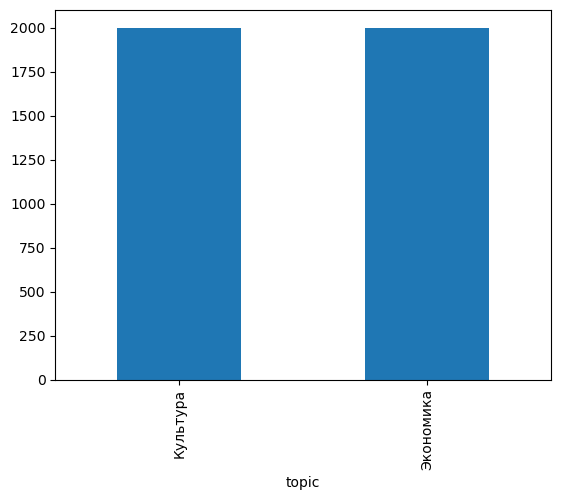

In [119]:
df["topic"].value_counts().plot(kind='bar')

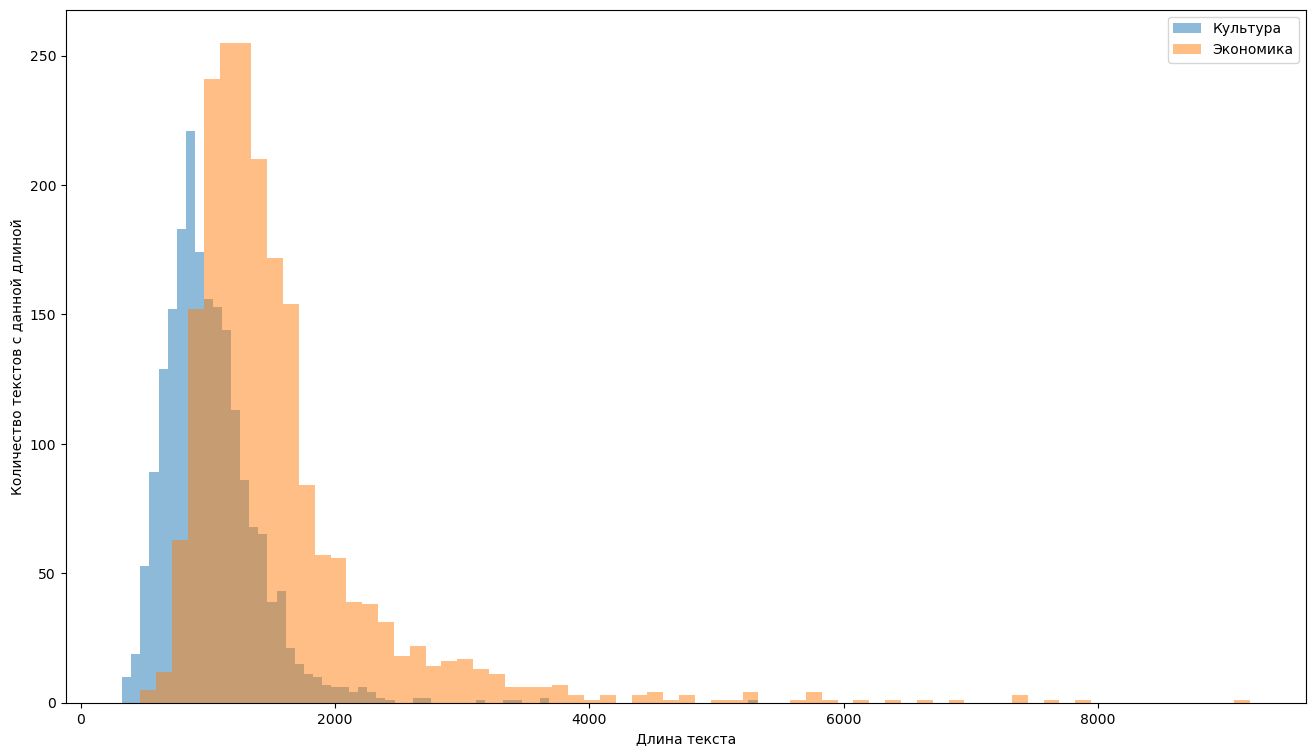

In [120]:
import matplotlib.pyplot as plt

df["text_len"] = df["text"].apply(len)
df.sort_values(by='text_len', ascending=True, inplace=True)

plt.figure(figsize=(16, 9))

for topic in df["topic"].unique():
    plt.hist(df[df["topic"] == topic]["text_len"], bins=70, alpha=0.5, label=topic)

plt.legend()
plt.xlabel('Длина текста')
plt.ylabel('Количество текстов с данной длиной')
plt.show()

**Задание 2.** Подсчитайте частоту встречаемости слов новостных текстов в датафрейме.

Какие слова употребляются наиболее часто в целом во всех новостных текстах, а какие слова употребляются в новостных текстах относительно тем (выведите топ-50 слов для каждого из случаев)?

In [121]:
pos_dict = {
    'A': 'прилагательное',
    'ADV': 'наречие',
    'ADVPRO': 'местоименное наречие',
    'ANUM': 'числительное-прилагательное',
    'APRO': 'местоимение-прилагательное',
    'COM': 'часть композита - сложного слова',
    'CONJ': 'союз',
    'INTJ': 'междометие',
    'NUM': 'числительное',
    'PART': 'частица',
    'PR': 'предлог',
    'S': 'существительное',
    'SPRO': 'местоимение-существительное',
    'V': 'глагол'
}

def parse_text(text):
    m = Mystem(entire_input=False)
    analytics = m.analyze(text)
    words_info = []

    for word in analytics:
        word_dict = {}
        try:
            word_dict["Слово"] = word["text"]
            word_dict["Лемма"] = word["analysis"][0]["lex"]

            match = re.match(r'[A-Z]*', word['analysis'][0]['gr'])
            if match:
                pos = pos_dict[match.group()]
                word_dict["Часть речи"] = pos

            word_dict["Грамматическая информация"] = word["analysis"][0]["gr"]

            if "qual" in word["analysis"][0] and word["analysis"][0]["qual"] == "bastard":
                word_dict["Присутствует в словаре"] = False
            else:
                word_dict["Присутствует в словаре"] = True
        except:
            word_dict["Слово"] = word["text"]
            word_dict["Лемма"] = word["text"]
            word_dict["Часть речи"] = None
            word_dict["Грамматическая информация"] = None
            word_dict["Присутствует в словаре"] = False

        words_info.append(word_dict)
    return words_info

In [122]:
def get_words_freqs(text):
    text = text.lower()
    text_info = parse_text(text)
    
    result_dict = {}

    for word_info in text_info:
        word = word_info["Слово"]
        if word not in result_dict:
            result_dict[word] = 1
        else:
            result_dict[word] += 1

    sorted_dict = sorted(result_dict.items(), key=lambda x: x[1], reverse=True)
    result = {}
    
    for word_info in sorted_dict:
        result[word_info[0]] = word_info[1]

    return result

In [123]:
all_texts = ' '.join(df["text"])
all_texts_words_freqs = get_words_freqs(all_texts)

In [124]:
top_50_words = list(all_texts_words_freqs.items())[:50]
top_50_words = pd.DataFrame(top_50_words, columns=['Слово', 'Частота'])

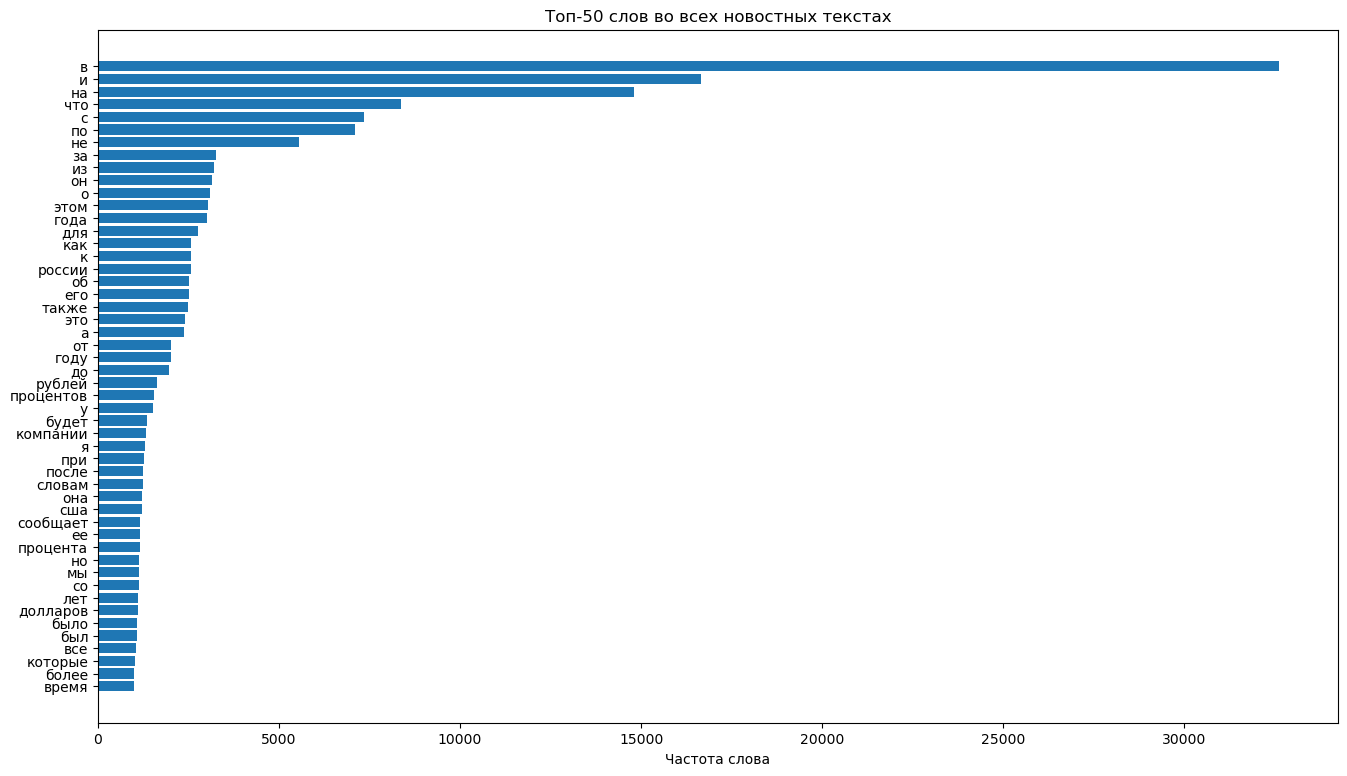

In [125]:
plt.figure(figsize=(16, 9))
plt.barh(top_50_words["Слово"][::-1], top_50_words["Частота"][::-1])
plt.title('Топ-50 слов во всех новостных текстах')
plt.xlabel('Частота слова')
plt.savefig('top_50_words.png')

In [126]:
culture_texts = ' '.join(df[df["topic"] == "Культура"]["text"])
culture_texts_words_freqs = get_words_freqs(culture_texts)

In [127]:
top_50_culture_words = list(culture_texts_words_freqs.items())[:50]
top_50_culture_words = pd.DataFrame(top_50_culture_words, columns=['Слово', 'Частота'])

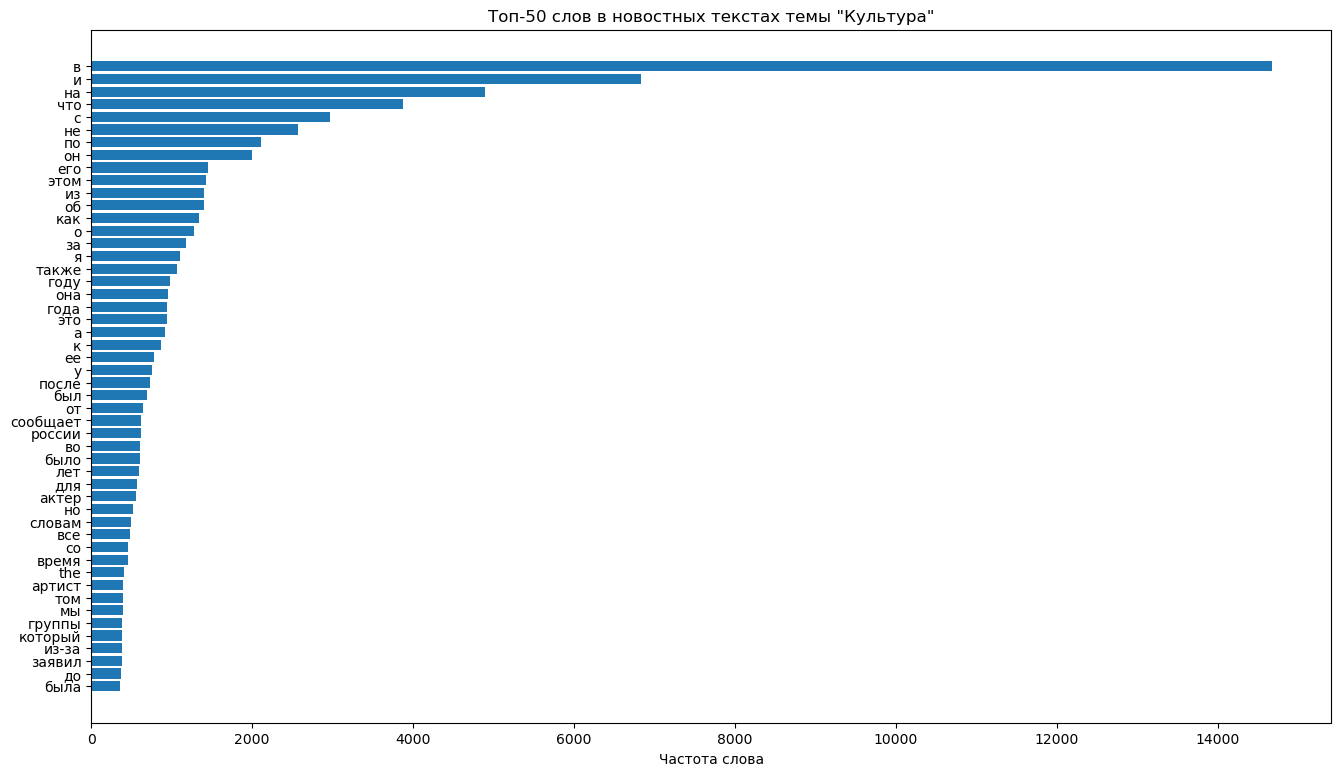

In [128]:
plt.figure(figsize=(16, 9))
plt.barh(top_50_culture_words["Слово"][::-1], top_50_culture_words["Частота"][::-1])
plt.title('Топ-50 слов в новостных текстах темы "Культура"')
plt.xlabel('Частота слова')
plt.savefig('top_50_culture_words.png')

In [129]:
economic_texts = ' '.join(df[df["topic"] == "Экономика"]["text"])
economic_texts_words_freqs = get_words_freqs(economic_texts)

In [130]:
top_50_economic_words = list(economic_texts_words_freqs.items())[:50]
top_50_economic_words = pd.DataFrame(top_50_economic_words, columns=['Слово', 'Частота'])

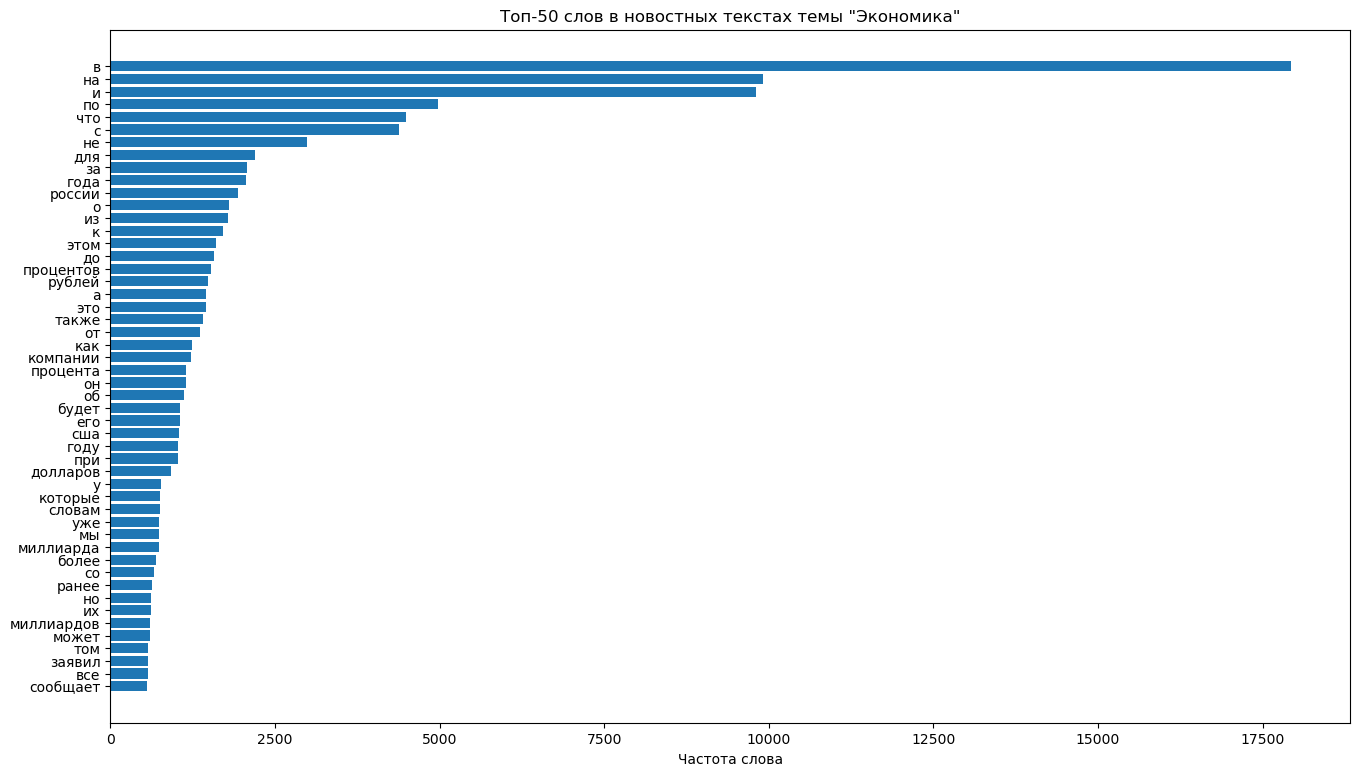

In [131]:
plt.figure(figsize=(16, 9))
plt.barh(top_50_economic_words["Слово"][::-1], top_50_economic_words["Частота"][::-1])
plt.title('Топ-50 слов в новостных текстах темы "Экономика"')
plt.xlabel('Частота слова')
plt.savefig('top_50_economic_words.png')

**Задание 3.** Обработайте тексты с помощью морфологического анализатора. Уберите стоп-слова. И повторите задание 2 для текстов из слов, приведённых в начальную форму. Сравните списки топ-50 из второго и третьего заданий. Сделайте выводы.

In [132]:
def is_stop_word(word_info):
    stop_words_poses = ["местоимение-существительное", "предлог", "частица", "междометие",  "союз", "местоимение-прилагательное", "местоименное наречие"]
    stop_words_lemmas = ["быть", "также", "уже"]
    
    return word_info["Часть речи"] in stop_words_poses or word_info["Лемма"] in stop_words_lemmas

def get_words_freqs(text):
    text = text.lower()
    text_info = parse_text(text)

    result_dict = {}

    for word_info in text_info:
        word = word_info["Лемма"]
        
        if is_stop_word(word_info):
            continue
        
        if word not in result_dict:
            result_dict[word] = 1
        else:
            result_dict[word] += 1

    sorted_dict = sorted(result_dict.items(), key=lambda x: x[1], reverse=True)
    result = {}

    for word_info in sorted_dict:
        result[word_info[0]] = word_info[1]

    return result

In [133]:
all_texts = ' '.join(df["text"])
all_texts_words_freqs = get_words_freqs(all_texts)

In [134]:
top_50_words = list(all_texts_words_freqs.items())[:50]
top_50_words = pd.DataFrame(top_50_words, columns=['Слово', 'Частота'])

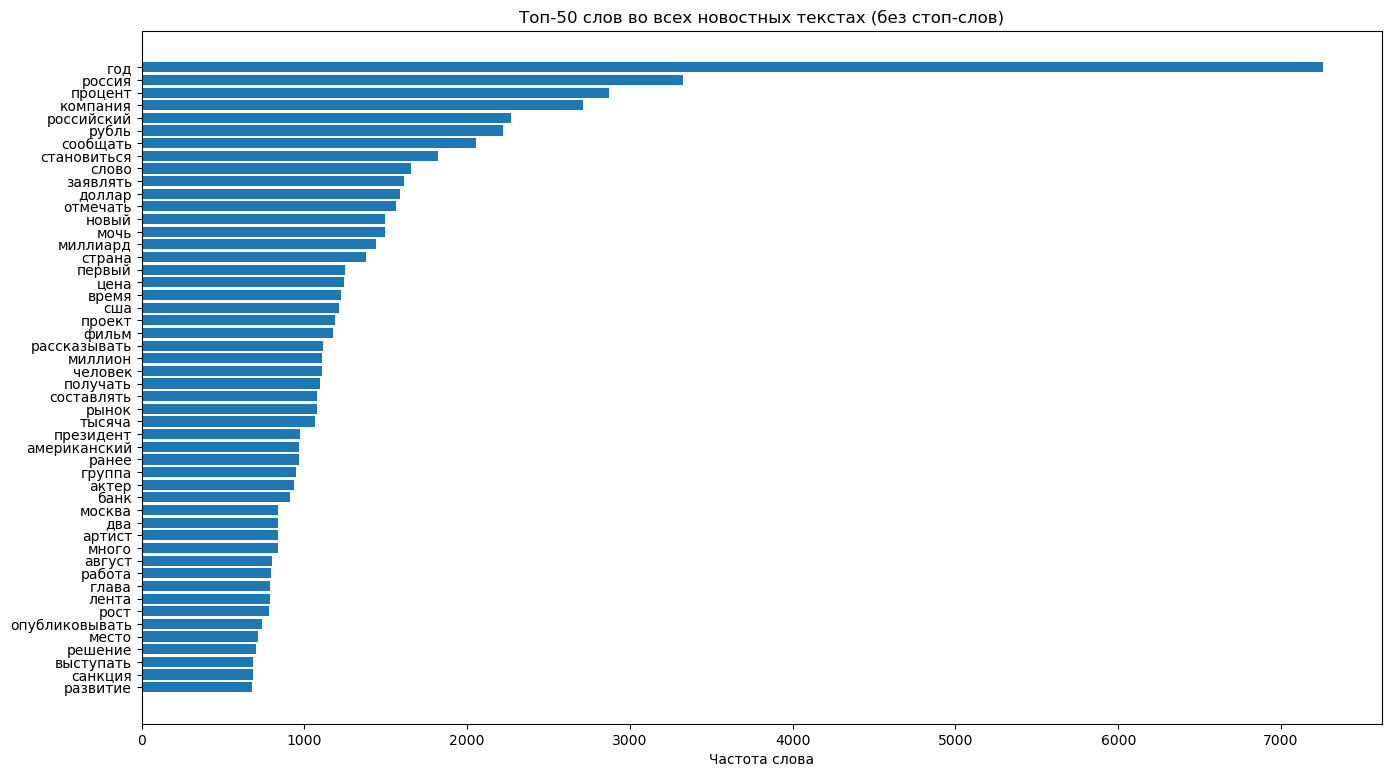

In [135]:
plt.figure(figsize=(16, 9))
plt.barh(top_50_words["Слово"][::-1], top_50_words["Частота"][::-1])
plt.title('Топ-50 слов во всех новостных текстах (без стоп-слов)')
plt.xlabel('Частота слова')
plt.savefig('top_50_words_no_stop_words.png')

In [136]:
culture_texts = ' '.join(df[df["topic"] == "Культура"]["text"])
culture_texts_words_freqs = get_words_freqs(culture_texts)

In [137]:
top_50_culture_words = list(culture_texts_words_freqs.items())[:50]
top_50_culture_words = pd.DataFrame(top_50_culture_words, columns=['Слово', 'Частота'])

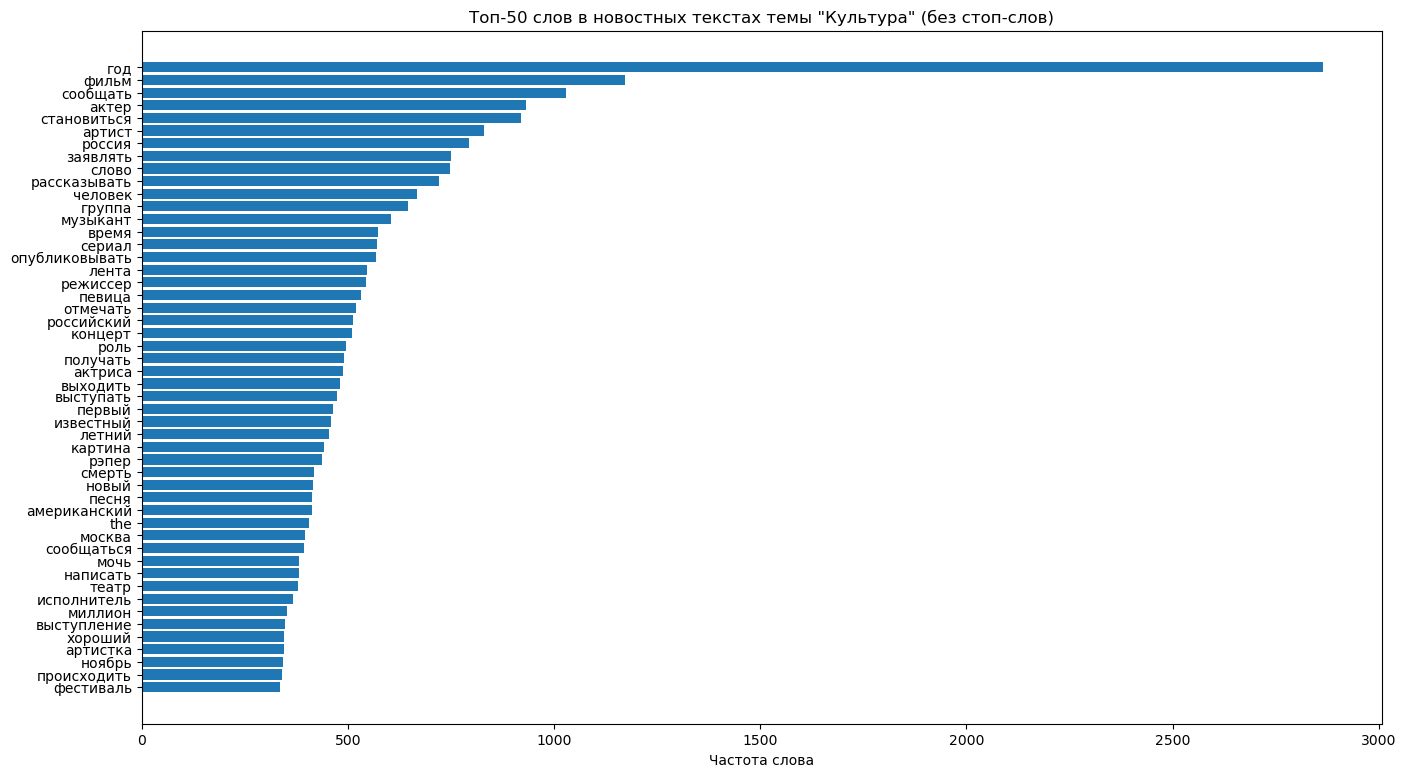

In [138]:
plt.figure(figsize=(16, 9))
plt.barh(top_50_culture_words["Слово"][::-1], top_50_culture_words["Частота"][::-1])
plt.title('Топ-50 слов в новостных текстах темы "Культура" (без стоп-слов)')
plt.xlabel('Частота слова')
plt.savefig('top_50_culture_words_no_stop_words.png')

In [139]:
economic_texts = ' '.join(df[df["topic"] == "Экономика"]["text"])
economic_texts_words_freqs = get_words_freqs(economic_texts)

In [140]:
top_50_economic_words = list(economic_texts_words_freqs.items())[:50]
top_50_economic_words = pd.DataFrame(top_50_economic_words, columns=['Слово', 'Частота'])

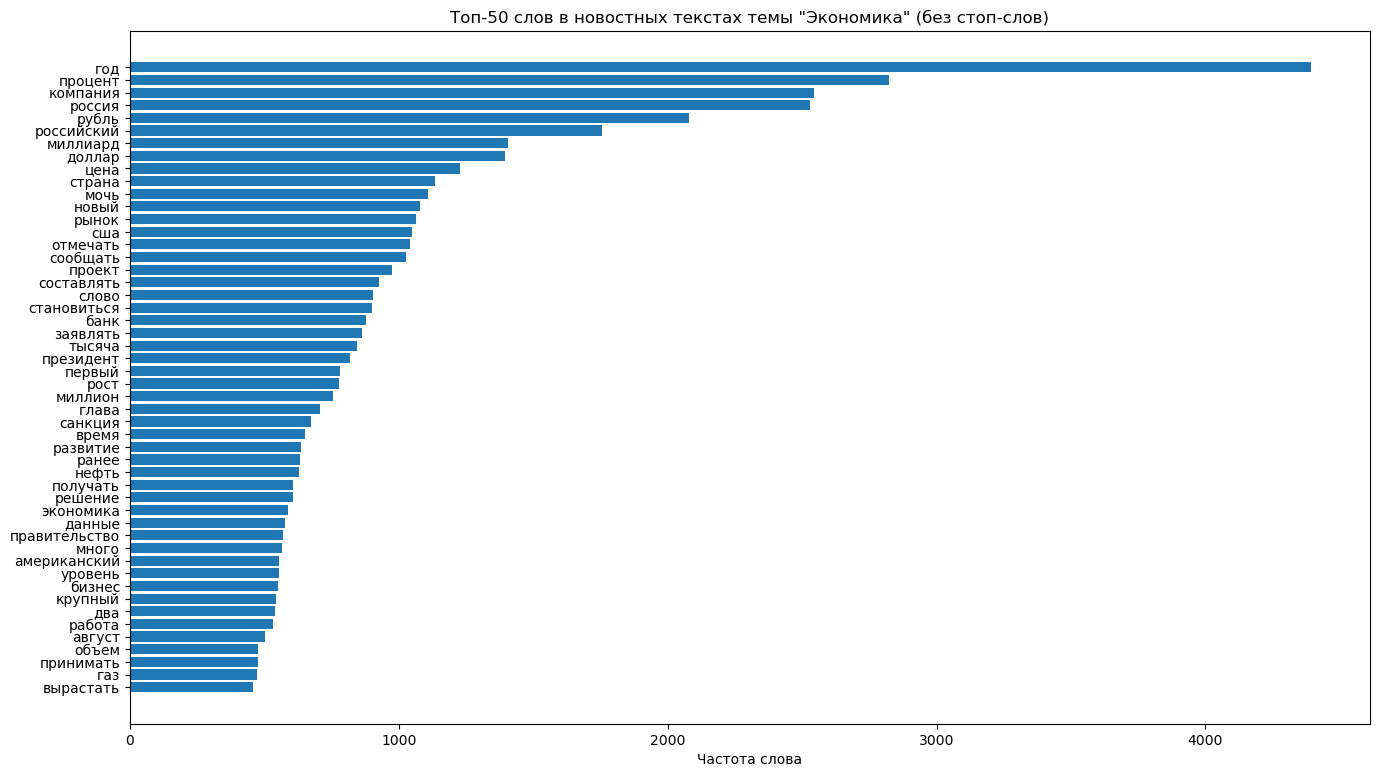

In [141]:
plt.figure(figsize=(16, 9))
plt.barh(top_50_economic_words["Слово"][::-1], top_50_economic_words["Частота"][::-1])
plt.title('Топ-50 слов в новостных текстах темы "Экономика" (без стоп-слов)')
plt.xlabel('Частота слова')
plt.savefig('top_50_economic_words_no_stop_words.png')

**Задание 4.** Разделите новостной датасет на обучающую и тестовую выборки. Постройте три классификатора, каждый из которых определяет тему новостного текста (модели выбирайте в соответствии со своими навыками). Сравните точности получившихся трёх классификаторов на тестовой и обучающей выборках, сделайте выводы.

Вектор признаков предлагается строить по аналогии как в примере из раздела `"Классификация текстов"` 12 главы `"Инструментарий естественного языка"` книги `"Основы python для data science"` (страницы `207`-`211`).

In [144]:
from sklearn.model_selection import train_test_split

texts = df["text"]
labels = df["topic"]

texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, shuffle=True, random_state=42, stratify=labels)

texts_train: (3200,)
texts_test: (800,)
labels_train: (3200,)
labels_test: (800,)


In [180]:
def vectorize(string, tell_words, lemmatizator):
    result = np.zeros_like(tell_words, dtype=int)   
    lemmas_array = lemmatizator.lemmatize(string)
    
    for lemma in lemmas_array:
        if lemma in tell_words:
            result[tell_words.index(lemma)] = 1
    
    return result

def vectorize_texts(texts : pd.Series):
    tell_words = list(set(top_50_culture_words["Слово"]) | set(top_50_economic_words["Слово"]))
    lemmatizator = Mystem()
    return texts.map(lambda x: vectorize(x, tell_words, lemmatizator))          

In [181]:
texts_train_vectorized = vectorize_texts(texts_train)
texts_test_vectorized = vectorize_texts(texts_test)

In [205]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

model = LogisticRegression()
model.fit(np.vstack(texts_train_vectorized), labels_train)
print(f'Точность на обучающей выборке: {model.score(np.vstack(texts_train_vectorized), labels_train)}')
print(f'Точность на тестовой выборке: {model.score(np.vstack(texts_test_vectorized), labels_test)}')

Точность на обучающей выборке: 0.98
Точность на тестовой выборке: 0.96625


In [206]:
model = SGDClassifier()
model.fit(np.vstack(texts_train_vectorized), labels_train)
print(f'Точность на обучающей выборке: {model.score(np.vstack(texts_train_vectorized), labels_train)}')
print(f'Точность на тестовой выборке: {model.score(np.vstack(texts_test_vectorized), labels_test)}')

Точность на обучающей выборке: 0.97875
Точность на тестовой выборке: 0.96


In [207]:
model = RandomForestClassifier()
model.fit(np.vstack(texts_train_vectorized), labels_train)
print(f'Точность на обучающей выборке: {model.score(np.vstack(texts_train_vectorized), labels_train)}')
print(f'Точность на тестовой выборке: {model.score(np.vstack(texts_test_vectorized), labels_test)}')

Точность на обучающей выборке: 1.0
Точность на тестовой выборке: 0.9675


In [213]:
model.predict(np.vstack(vectorize_texts(pd.Series("Запасаемся салфетками: вышла самая трогательная игра про кошку, которой нужно вернуться домой — Copycat. Сюжет такой: котейку забрали из приюта в новый дом, но однажды её место занял клон, который прогнал бедную кису на улицу. Теперь ей нужно выживать в жестоком мире. Геймеры отмечают, что тайтл не такой уж и добрый, как пишут в описании Steam — игра давит из вас слёзы и создаёт эмоциональные качели."))))

array(['Культура'], dtype=object)

In [214]:
model.predict(np.vstack(vectorize_texts(pd.Series("С 1 ноября банки РФ не смогут брать комиссию с клиентов за платежи в пользу государства (оплата налогов, штрафов, детских садов и др.), — ЦБ РФ. В то же время лимит на бесплатные переводы в размере 100 тыс. руб. будет распространен на операции с электронными кошельками, указывает регулятор."))))

array(['Экономика'], dtype=object)